# 🔥 Introduction to `PyTorch` -- Algorithmic Differentiation

[Deep Learning](https://dsai.units.it/index.php/courses/deep-learning/) Course @ [UniTS](https://portale.units.it/en), Spring 2024

<a target="_blank" href="https://colab.research.google.com/github/emaballarin/deeplearning-units/blob/main/labs/01_intro_to_pytorch/03_pytorch_autodiff.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>  <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/emaballarin/deeplearning-units/blob/main/labs/01_intro_to_pytorch/03_pytorch_autodiff.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

### Towards gradient-based model fitting

In the previous notebook, we defined a simple linear model and to fitted it to data using its analytical OLS solution. In general, especially in complex cases, we cannot rely on analytical solutions and we need to resort to numerical optimization. Specifically, we would like to apply **gradient-based optimization** to fit our model to data.

But first, we need to compute such gradients! 🙃

PyTorch is built with differentiation in mind. Generally speaking, all of PyTorch built-in functions support algorithmic differentiability (unless the function is pathologically non-differentiable). This also includes functions that are not differentiable in the proper mathematical sense! For a more detailed discussion about differentiation in such cases, see [the official documentation](https://pytorch.org/docs/main/notes/autograd.html#gradients-for-non-differentiable-functions).

### Preliminary infrastucture setup

In [1]:
import os

FOLDERNAME: str = "deeplearning_units_2024"
try:
    if os.getenv("COLAB_RELEASE_TAG"):
        # noinspection PyUnresolvedReferences
        from google.colab import drive

        drive.mount(BASEPATH := "/content/drive")
        os.makedirs(FULLPATH := BASEPATH + "/MyDrive/" + FOLDERNAME, exist_ok=True)
    elif os.getenv("KAGGLE_CONTAINER_NAME"):
        os.makedirs(FULLPATH := "/kaggle/working/" + FOLDERNAME, exist_ok=True)
    else:
        os.makedirs(FULLPATH := "./" + FOLDERNAME, exist_ok=True)
    os.chdir(FULLPATH)
except (ModuleNotFoundError, FileExistsError, FileNotFoundError):
    pass

In [2]:
!python -m pip install -q icecream

In [3]:
# Pretty printouts
from icecream import ic

ic.configureOutput(outputFunction=print)
ic.configureOutput(prefix="    | ")

### Some imports

In [4]:
import torch as th
from torch import Tensor
from typing import Callable, Tuple, List
from matplotlib import pyplot as plt

### Let's differentiate!

Practically speaking, each torch `Tensor` has a boolean attribute `requires_grad`, which tells the algorithmic differentiation engine (`autograd`) whether it should keep track of operations on the tensor or not -- for the purpose of computing gradients.

When we perform operations on tensors with `requires_grad=True`, PyTorch builds a computational graph of operations on tensors. This graph is then used to compute the gradients of the final output with respect to the input tensors, using the chain rule of calculus (implemented efficiently, in *reverse mode*, by the ***backpropagation algorithm***).

In [5]:
x: Tensor = th.rand(3, 3)

In [6]:
_ = ic(x.requires_grad)

    | x.requires_grad: False


We can manually set the `requires_grad` attribute to `True`, or create directly a Tensor with it pre-set.

In [7]:
x.requires_grad_(
    True
)  # Note: usually, the underscore at the end of a method name in PyTorch means "in-place"

# Or alternatively:
y: Tensor = th.rand(3, 3, requires_grad=True)

In [8]:
_ = ic(x.requires_grad, y.requires_grad)

    | x.requires_grad: True, y.requires_grad: True


In [9]:
# Cleanup
del x, y

### Differentiation of functions

Now, let's compute a derivative of a function!

We consider first a function $f : \mathbb{R} \to \mathbb{R}$, *e.g.* $f(x) = x^2$. We would like to compute its derivative at a given (randomly chosen) point $x$.

In [10]:
x: Tensor = th.rand(1, requires_grad=True)
y: Tensor = x**2

In [11]:
# In this specific case:
_ = ic(x)
_ = ic(y)

    | x: tensor([0.9492], requires_grad=True)
    | y: tensor([0.9010], grad_fn=<PowBackward0>)


To compute gradients, we call the `backward` method of the output tensor. This method computes the gradients of the output with respect to the input tensors. It is important to note that the `backward` method can only be called on a **scalar output tensor**. In this case, output tensor `y` is a scalar, so we can call `backward` on it.

In [12]:
y.backward()

The gradient of $y$ with respect to $x$ is stored in the `grad` attribute of the input tensor `x`.

In [13]:
_ = ic(x.grad)

    | x.grad: tensor([1.8984])


We can also check that the gradient is correct by computing the derivative of $f(x) = x^2$ analytically: $f'(x) = 2x$.

In [14]:
_ = ic(2 * x == x.grad)

    | 2 * x == x.grad: tensor([True])


The same can be applied to a function $f : \mathbb{R}^d \to \mathbb{R}$, *e.g.* $f(\mathbf{x}) = \sum_{i=1}^d \mathbf{x}_i$.

In [15]:
x: Tensor = th.rand(3, requires_grad=True)
y: Tensor = x.sum()
y.backward()

In [16]:
_ = ic(x.grad)

    | x.grad: tensor([1., 1., 1.])


### Composed functions and the computational graph

We can use also compute the gradient of a composition of functions. For our objective, it is useful to think of such composition in terms of a *computational graph*. That is, we can interpret the composed function $g \circ f$ (such that $y = g(f(x))$) as a sequence of operations on tensors, which can be represented as a graph.

Specifically:
$z = f(x)$
$y = g(z)$

Which becomes, graphically:

![](https://i.ibb.co/D74Gv43/compgra2.jpg)

\
Now, let's suppose that $y = \log^2(x)$, *i.e.*: $z=f(x)=\log(x)$ and $y=g(z)=z^2$.

We expect that $\frac{dy}{dx}=2\frac{\log(x)}{|x|}$

In [17]:
x: Tensor = th.rand(1, requires_grad=True)
z: Tensor = x.log()
y: Tensor = z**2

_ = ic(x, z, y)

    | x: tensor([0.5664], requires_grad=True)
      z: tensor([-0.5685], grad_fn=<LogBackward0>)
      y: tensor([0.3232], grad_fn=<PowBackward0>)


In [18]:
# z.retain_grad()    # Ignore this for now, we will discuss it later...
y.backward()
_ = ic(x.grad == 2 * x.log() / x)

    | x.grad == 2 * x.log() / x: tensor([True])


Now, suppose we want to access $\frac{dy}{dz}=2z$

In [19]:
_ = ic(z.grad)
_ = ic(z.grad == 2 * z)

    | z.grad: None
    | z.grad == 2 * z: False


/tmp/ipykernel_2235/1087612663.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1709970096560/work/build/aten/src/ATen/core/TensorBody.h:489.)
  _ = ic(z.grad)
/tmp/ipykernel_2235/1087612663.py:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor inst

As the error message suggests, we need to explicitly retain the gradient on non-leaf (roughly: neither input nor output) tensors. This is done for memory-efficiency reasons, as storing gradients for all tensors in the computational graph would be wasteful in typical scenarios. We can do this by calling the `retain_grad` method on the tensor.

### `None` gradients, gradient accumulation, and graph retention

Before the `backward` method is called, the gradient of the output tensor with respect to the input tensors is `None`. This is also the case for non-retained intermediate tensors in the computational graph.


In [20]:
x: Tensor = th.rand(1, requires_grad=True)
z: Tensor = x.log()
y: Tensor = z**2

In [21]:
_ = ic(x.grad, z.grad)

    | x.grad: None, z.grad: None


/tmp/ipykernel_2235/1827219229.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1709970096560/work/build/aten/src/ATen/core/TensorBody.h:489.)
  _ = ic(x.grad, z.grad)


If we call `backward` on `y`, the gradient of `y` with respect to `x` is computed and stored in `x.grad`. However, if we call `backward` again, the gradients accumulate (*i.e.*, sum). This may become useful in some scenarios. If we want to reset the gradient, we must zero it or set it to None manually.

In [22]:
y.backward()
_ = ic(x.grad)

    | x.grad: tensor([-3.6354])


In [23]:
# We must re-define our graph, otherwise...
z: Tensor = x.log()
y: Tensor = z**2

In [24]:
y.backward()
_ = ic(x.grad)

    | x.grad: tensor([-7.2708])


What would happen if we did not re-define the graph, but we called `backward` on `y` again?

In [25]:
try:
    y.backward()
except RuntimeError as e:
    print(f"SUPPRESSED RuntimeError: {e}\n")

SUPPRESSED RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.



To avoid this, we can set the `retain_graph` argument of `backward` to `True`. This will retain the computational graph, so that we can call `backward` multiple times without re-defining the graph.

In [26]:
z: Tensor = x.log()
y: Tensor = z**2
y.backward(retain_graph=True)
_ = ic(x.grad)

    | x.grad: tensor([-10.9062])


In [27]:
y.backward()

In [28]:
_ = ic(x.grad)

    | x.grad: tensor([-14.5416])


### Disabling gradient tracking

We can also disable gradient tracking by wrapping the computation in a `with th.no_grad():` block. This is useful when we are only interested in *forward* computation, and we want to save memory and time.

In [29]:
x: Tensor = th.rand(1, requires_grad=True)
with th.no_grad():
    y: Tensor = x**2

In [30]:
try:
    y.backward()
except RuntimeError as e:
    print(f"SUPPRESSED RuntimeError: {e}\n")
_ = ic(x.grad)

SUPPRESSED RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

    | x.grad: None


### Bonus content: pure-gradient function minimization

As a toy example, we can use the gradients so obtained to minimize a 1D function iteratively. This may seem -- and indeed it is -- a very naive approach, but it is a good way to understand the basic principles of gradient-based optimization in PyTorch.

In [31]:
def minimize_1d(
    f: Callable[[Tensor], Tensor], x0: float, lr: float = 2e-3, n_steps: int = int(1e4)
) -> Tuple[float, List[float]]:
    x: Tensor = th.tensor(x0, requires_grad=True, dtype=th.float32)
    path: List[float] = [x.item()]
    for _ in range(n_steps):
        y: Tensor = f(x)
        y.backward()
        x.data -= lr * x.grad
        x.grad.zero_()
        path.append(x.item())
    return x.item(), path

As a starting point, let's consider a simple parabola.

In [32]:
f = lambda x: (x - 2) ** 2
xhat, xpath = minimize_1d(f, -4)

And let's plot the result. The function is shown in blue. In red, we mark the minimum found; in orange, we plot the path followed by the optimization algorithm.

In [33]:
x = th.linspace(-10, 10, 1000)

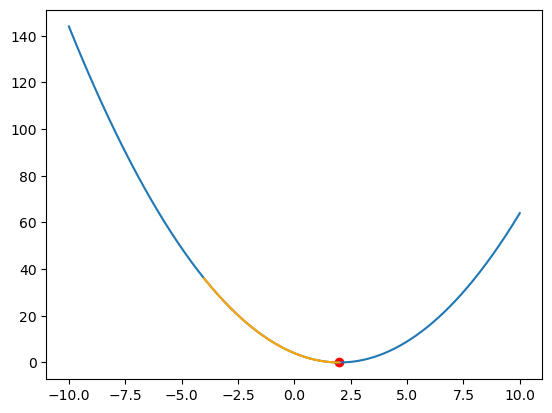

In [34]:
plt.plot(x, f(x))
plt.scatter(xhat, f(th.tensor(xhat)).item(), color="red")
plt.plot(xpath, [f(th.tensor(xi)).item() for xi in xpath], color="orange")

What about a more interesting example?

In [35]:
def sinpar(x: Tensor) -> Tensor:
    return th.sin(x) * x**2

In [36]:
xhat, xpath = minimize_1d(sinpar, -10, n_steps=1000)

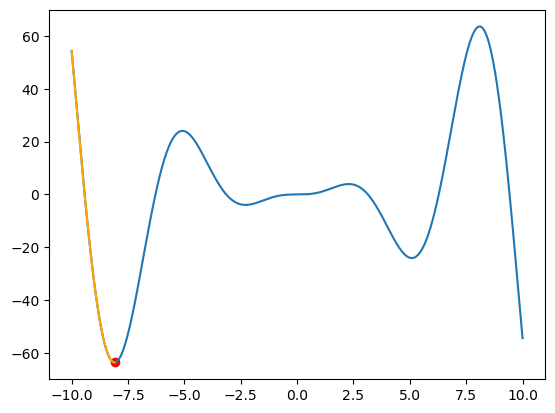

In [37]:
plt.plot(x, [sinpar(xi) for xi in x])
plt.scatter(xhat, sinpar(th.tensor(xhat)).item(), color="red")
plt.plot(xpath, [sinpar(th.tensor(xi)).item() for xi in xpath], color="orange")

What if we change the starting point? 🤔 Do you see any issues?